In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import json

# Feature Selection

In [2]:
def fishers_criterion(df, class1, class2): 
    
    # exclude label columns
    feature_columns = [col for col in df.columns if col not in ["Participant_ID", "Depression", "Gender"]]
    
    fisher_scores = pd.Series(index=feature_columns, dtype=float)

    # Calculate Fisher's Score for each feature
    for col in feature_columns:
        m1 = class1[col].mean()
        m2 = class2[col].mean()
        s1 = class1[col].var()
        s2 = class2[col].var()
        
        if (s1 + s2) == 0: 
            score = 0
        else:
            score = (m2 - m1)**2 / (s1 + s2)
        fisher_scores[col] = score

    return fisher_scores

In [3]:
train_df = pd.read_csv("data/train_data_final.csv")
test_df = pd.read_csv("data/test_data_final.csv")
train_df.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Participant_ID,Depression,Gender
0,33.883310,0.188470,31.197649,31.198807,31.237043,0.039394,39.990345,28.040092,100.798780,0.000000,...,1.960784,2.061856,0.240000,0.010000,0.225,0.005000,-53.529380,448,1,1
1,23.442284,0.015231,23.083265,23.519197,23.799660,0.716394,0.000000,0.000000,-0.109734,0.000000,...,3.703704,2.040816,0.080000,0.000000,0.380,0.000000,-47.326970,448,1,1
2,26.658195,0.095594,24.275490,27.404346,29.017082,4.741592,61.829530,67.673560,20.461290,11.705440,...,3.131991,2.036199,0.344444,0.235472,0.115,0.087321,-41.121784,448,1,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.333334,0.000000,0.000000,0.000000,0.240,0.000000,-56.265000,448,1,1
4,34.614662,0.005980,34.433628,34.559757,34.764160,0.330532,8.279264,5.828207,8.208370,6.596444,...,5.084746,1.886793,0.420000,0.000000,0.040,0.020000,-33.531155,448,1,1


# Determining Collinearity

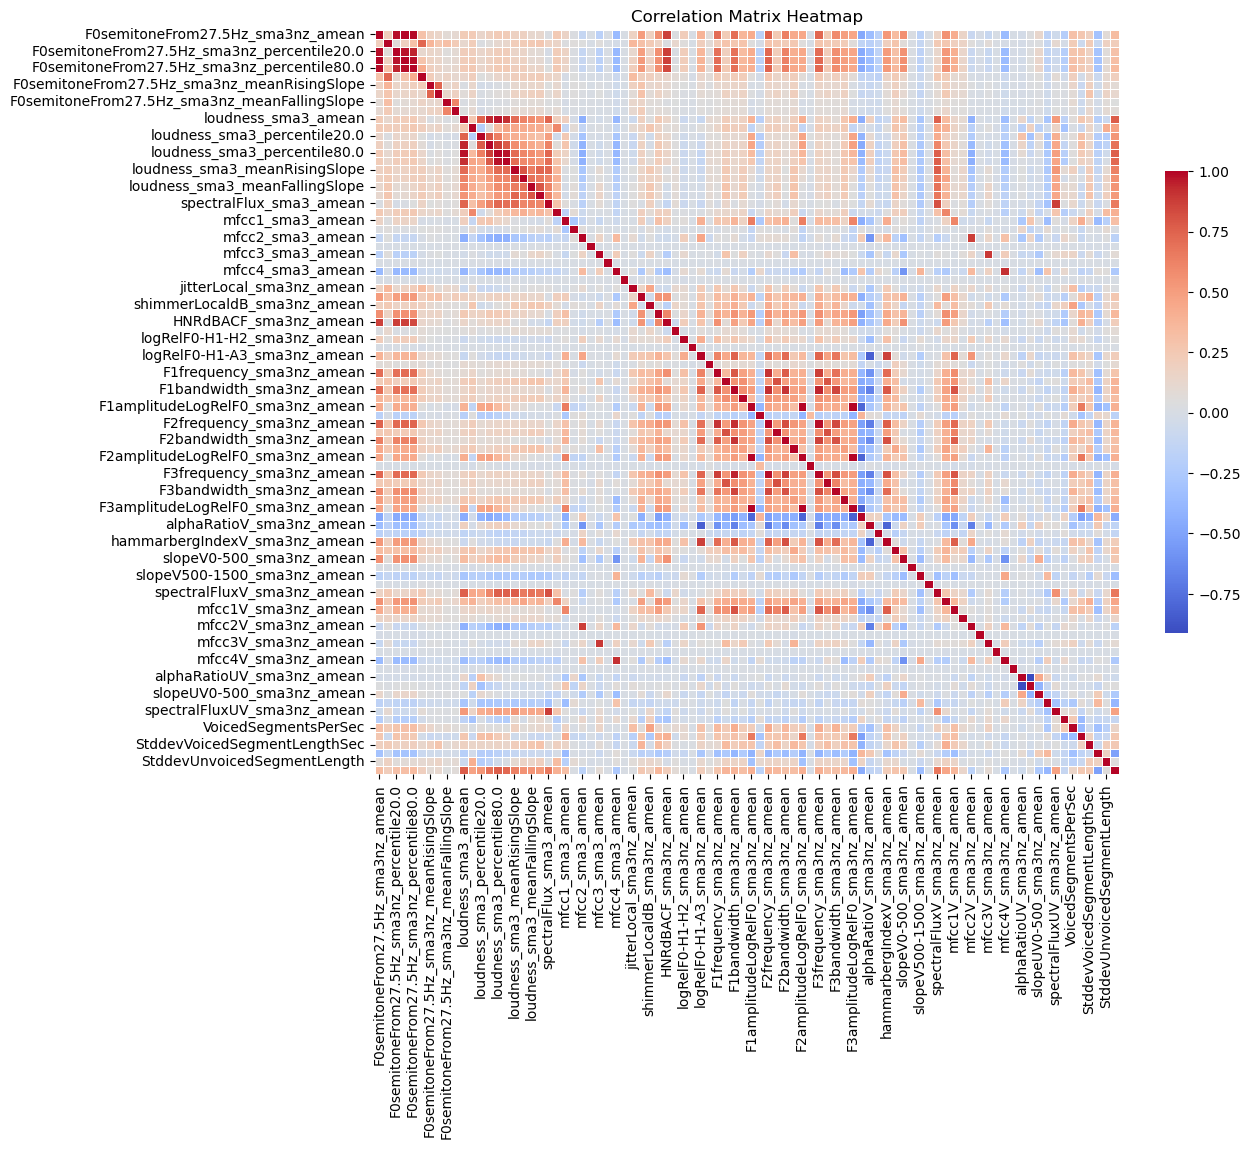

In [4]:
feature_columns = [col for col in train_df.columns if col not in ["Participant_ID", "Depression", "Gender"]]
feature_df = train_df[feature_columns]

corr_matrix = train_df.corr()
feature_matrix = feature_df.corr()

plt.figure(figsize=(12, 12))

sns.heatmap(feature_matrix, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

In [5]:
# don't include diagonal features
mask = (feature_matrix > 0.8) | (feature_matrix < -0.8)
high_vals = mask.sum().sum()
total_vals = len(feature_matrix) ** 2

print("Proportion of features with correlation threshold (0.8, -0.8): ", high_vals/total_vals)

Proportion of features with correlation threshold (0.8, -0.8):  0.02350206611570248


In [6]:
# now I need to figure out which pairs of columns these are

high_corr = feature_matrix[mask]

collinear_pairs = []
for row in high_corr.index:
    for col in high_corr.columns:
        if row == col:
            continue
        if pd.notnull(high_corr.loc[row, col]):
            print(f"row {row}\n and column {col}\n correlation: {high_corr.loc[row,col]}\n")
            if (col, row) in collinear_pairs:
                continue
            collinear_pairs.append((row, col))


row F0semitoneFrom27.5Hz_sma3nz_amean
 and column F0semitoneFrom27.5Hz_sma3nz_percentile20.0
 correlation: 0.982034389278973

row F0semitoneFrom27.5Hz_sma3nz_amean
 and column F0semitoneFrom27.5Hz_sma3nz_percentile50.0
 correlation: 0.9940625874589571

row F0semitoneFrom27.5Hz_sma3nz_amean
 and column F0semitoneFrom27.5Hz_sma3nz_percentile80.0
 correlation: 0.9868243459709892

row F0semitoneFrom27.5Hz_sma3nz_amean
 and column HNRdBACF_sma3nz_amean
 correlation: 0.870462649276386

row F0semitoneFrom27.5Hz_sma3nz_percentile20.0
 and column F0semitoneFrom27.5Hz_sma3nz_amean
 correlation: 0.982034389278973

row F0semitoneFrom27.5Hz_sma3nz_percentile20.0
 and column F0semitoneFrom27.5Hz_sma3nz_percentile50.0
 correlation: 0.9760603653909143

row F0semitoneFrom27.5Hz_sma3nz_percentile20.0
 and column F0semitoneFrom27.5Hz_sma3nz_percentile80.0
 correlation: 0.9468942883218004

row F0semitoneFrom27.5Hz_sma3nz_percentile20.0
 and column HNRdBACF_sma3nz_amean
 correlation: 0.8781113981900466

ro

In [7]:
high_corr

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
F0semitoneFrom27.5Hz_sma3nz_amean,1.000000,NaN,0.982034,0.994063,0.986824,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_stddevNorm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.982034,NaN,1.000000,0.976060,0.946894,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.994063,NaN,0.976060,1.000000,0.978945,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.986824,NaN,0.946894,0.978945,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MeanVoicedSegmentLengthSec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
StddevVoicedSegmentLengthSec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
MeanUnvoicedSegmentLength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
StddevUnvoicedSegmentLength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [8]:
len(collinear_pairs)

47

#### Create a correlation DataFrame to store results

In [9]:
columns = ["d_corr", "d_fisher", "g_corr", "g_fisher"]
rows = corr_matrix.index

final_corr = pd.DataFrame(np.nan, index=rows, columns=columns)
final_corr.index.name = "features"
final_corr.head()

,d_corr,d_fisher,g_corr,g_fisher
features,,,,
F0semitoneFrom27.5Hz_sma3nz_amean,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_stddevNorm,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_percentile20.0,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_percentile50.0,NaN,NaN,NaN,NaN
F0semitoneFrom27.5Hz_sma3nz_percentile80.0,NaN,NaN,NaN,NaN


# Feature Selection for Depression Detection

Testing 2 filters: correlation and fisher's criterion to determine the most informative features for depression detection 

## 1) Correlation Criterion

Find the top 20 features that are correlated with predicting depression

In [18]:
depression_corr = corr_matrix["Depression"]
final_corr["d_corr"] = depression_corr

sorted_corr = depression_corr.sort_values(ascending=False)
top_20_depression_corr_positive = sorted_corr[1:11]
top_20_depression_corr_negative = sorted_corr[-11:-1]

<BarContainer object of 10 artists>

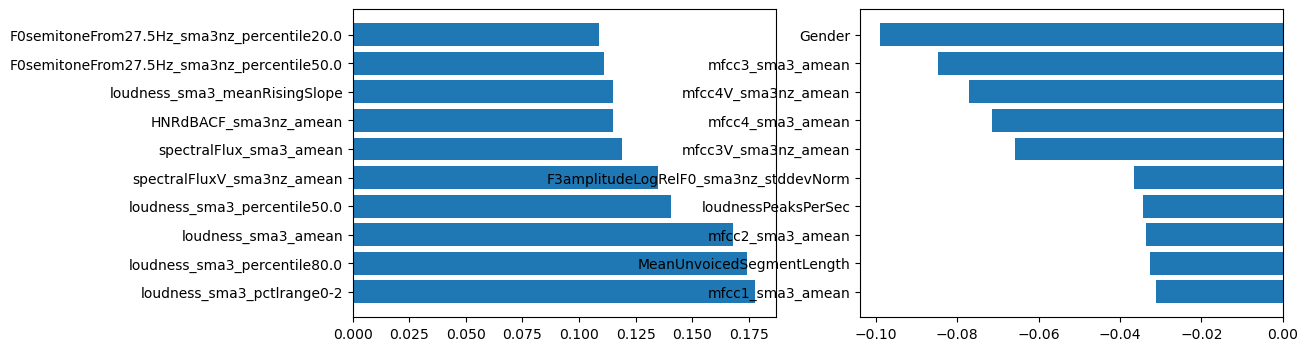

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax = ax.flatten()

ax[0].barh(top_20_depression_corr_positive.index, top_20_depression_corr_positive.values)
ax[1].barh(top_20_depression_corr_negative.index, top_20_depression_corr_negative.values)

In [23]:
top_20_depression_corr_positive

features
loudness_sma3_pctlrange0-2                    0.177983
loudness_sma3_percentile80.0                  0.174240
loudness_sma3_amean                           0.168146
loudness_sma3_percentile50.0                  0.140475
spectralFluxV_sma3nz_amean                    0.134920
spectralFlux_sma3_amean                       0.119005
HNRdBACF_sma3nz_amean                         0.115207
loudness_sma3_meanRisingSlope                 0.114811
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    0.110978
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.108764
Name: Depression, dtype: float64

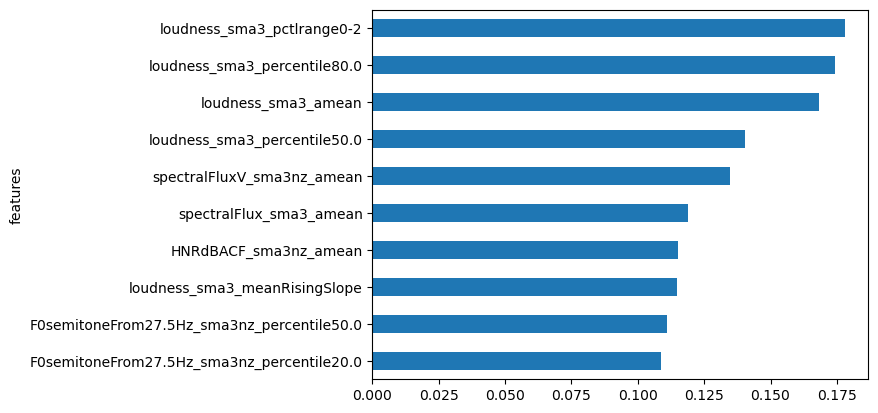

In [24]:
top_20_depression_corr_positive.plot(kind='barh').invert_yaxis()

<Axes: ylabel='features'>

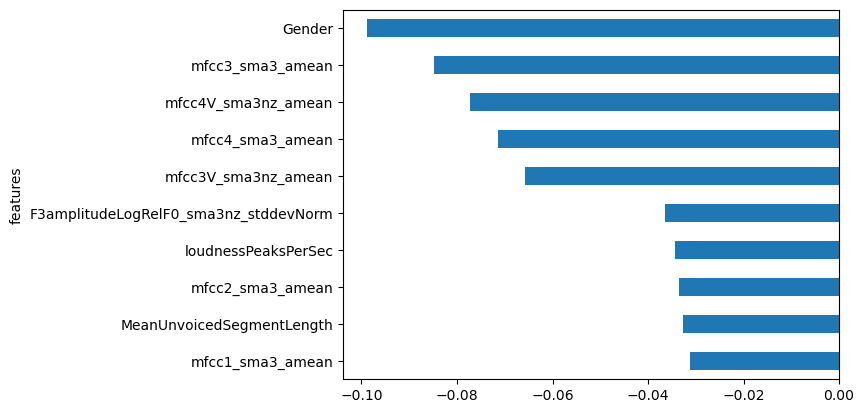

In [25]:
top_20_depression_corr_negative.plot(kind='barh')

## Discuss these top 20 features

## 2) Fisher's Criterion

split features into 2 classes for depression and perform fisher's criterion for all features

In [26]:
d_detected = train_df[train_df["Depression"] == 1]
d_not_detected = train_df[train_df["Depression"] == 0]

fisher_depression = fishers_criterion(train_df, d_detected, d_not_detected)
final_corr["d_fisher"] = fisher_depression

In [27]:
top_20_depression_fisher = fisher_depression.sort_values(ascending=False)[:20]
print(top_20_depression_fisher)

loudness_sma3_pctlrange0-2                    0.064118
loudness_sma3_percentile80.0                  0.061063
loudness_sma3_amean                           0.056849
loudness_sma3_percentile50.0                  0.040183
spectralFluxV_sma3nz_amean                    0.036043
HNRdBACF_sma3nz_amean                         0.032438
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    0.030454
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    0.029254
spectralFlux_sma3_amean                       0.028903
F0semitoneFrom27.5Hz_sma3nz_amean             0.028664
loudness_sma3_meanRisingSlope                 0.027396
F0semitoneFrom27.5Hz_sma3nz_percentile80.0    0.026888
loudness_sma3_meanFallingSlope                0.022886
loudness_sma3_stddevRisingSlope               0.020044
spectralFluxV_sma3nz_stddevNorm               0.019985
equivalentSoundLevel_dBp                      0.019842
loudness_sma3_stddevFallingSlope              0.017539
mfcc3_sma3_amean                              0.016978
F1frequenc

## Discuss these top 20 features

# Feature Selection for Gender Detection

## 1) Correlation Criterion

Find the top 20 features that are correlated with predicting gender

In [29]:
gender_corr = corr_matrix["Gender"]
final_corr["g_corr"] = gender_corr

gender_corr = gender_corr.sort_values(ascending=False)

sorted_corr = gender_corr.sort_values(ascending=False)
top_20_gender_corr_positive = sorted_corr[1:11]
top_20_gender_corr_negative = sorted_corr[-11:-1]

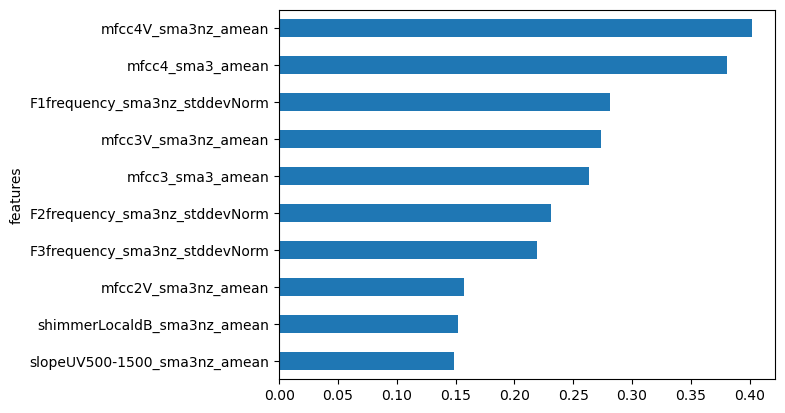

In [32]:
top_20_gender_corr_positive.plot(kind="barh").invert_yaxis()

In [33]:
top_20_gender_corr_positive

features
mfcc4V_sma3nz_amean              0.401659
mfcc4_sma3_amean                 0.381066
F1frequency_sma3nz_stddevNorm    0.281449
mfcc3V_sma3nz_amean              0.273940
mfcc3_sma3_amean                 0.263410
F2frequency_sma3nz_stddevNorm    0.230929
F3frequency_sma3nz_stddevNorm    0.219330
mfcc2V_sma3nz_amean              0.157406
shimmerLocaldB_sma3nz_amean      0.152319
slopeUV500-1500_sma3nz_amean     0.148663
Name: Gender, dtype: float64

<Axes: ylabel='features'>

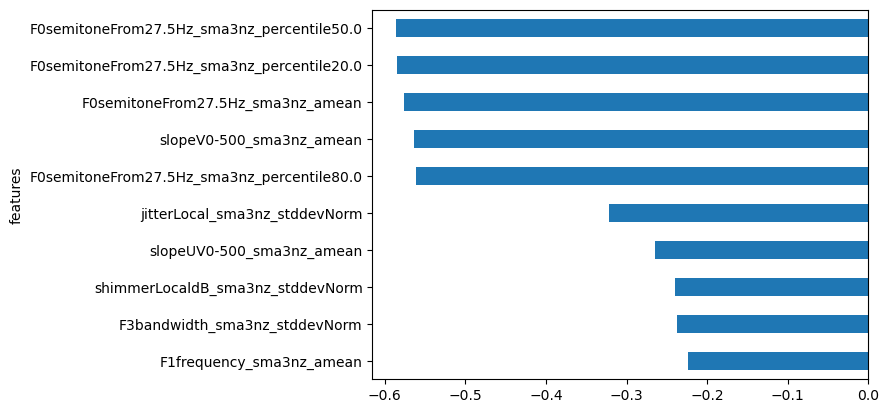

In [31]:
top_20_gender_corr_negative.plot(kind="barh")

## 2) Fisher's Criterion

split features into 2 classes for gender and perform fisher's criterion for all features

In [18]:
g_detected = train_df[train_df["Gender"] == 1]
g_not_detected = train_df[train_df["Gender"] == 0]

fisher_gender = fishers_criterion(train_df, g_detected, g_not_detected)
final_corr["g_fisher"] = fisher_gender

In [19]:
top_20_gender_fisher = fisher_gender.sort_values(ascending=False)[:20]
print(top_20_gender_fisher)

HNRdBACF_sma3nz_amean                         1.279805
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    1.050623
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    1.036141
F0semitoneFrom27.5Hz_sma3nz_amean             1.001286
slopeV0-500_sma3nz_amean                      0.954260
F0semitoneFrom27.5Hz_sma3nz_percentile80.0    0.933077
mfcc4V_sma3nz_amean                           0.399000
mfcc4_sma3_amean                              0.349772
jitterLocal_sma3nz_stddevNorm                 0.224661
F1frequency_sma3nz_stddevNorm                 0.189177
mfcc3V_sma3nz_amean                           0.169913
slopeUV0-500_sma3nz_amean                     0.156204
mfcc3_sma3_amean                              0.155971
shimmerLocaldB_sma3nz_stddevNorm              0.123856
F2frequency_sma3nz_stddevNorm                 0.123605
F3bandwidth_sma3nz_stddevNorm                 0.121498
F1frequency_sma3nz_amean                      0.109861
F3frequency_sma3nz_stddevNorm                 0.109457
spectralFl

## Saving results To correlation.csv

In [20]:
final_corr.iloc[:-3,:].tail(20)

,d_corr,d_fisher,g_corr,g_fisher
features,,,,
mfcc1V_sma3nz_amean,-0.030127,0.002344,0.123356,0.032806
mfcc1V_sma3nz_stddevNorm,0.027725,0.002091,-0.063516,0.006998
mfcc2V_sma3nz_amean,-0.013415,0.000420,0.157406,0.051860
mfcc2V_sma3nz_stddevNorm,0.012537,0.000436,0.008747,0.000143
mfcc3V_sma3nz_amean,-0.065792,0.010301,0.273940,0.169913
mfcc3V_sma3nz_stddevNorm,-0.017123,0.000489,0.003923,0.000026
mfcc4V_sma3nz_amean,-0.077183,0.014138,0.401659,0.399000
mfcc4V_sma3nz_stddevNorm,0.012298,0.000252,0.018072,0.000808
alphaRatioUV_sma3nz_amean,0.026974,0.001797,0.055541,0.006596


In [21]:
final_corr.iloc[:-3,:].to_csv("outputs/correlation.csv", index=True)

# Optimizing Feature Selection for Depression

## 1) Mitigate bias by removing gender-based features

Idea: Remove the m = [5, 10, 15, ..., 30] most important features for gender classification from the original dataset and run the algorithm to determine best results

## 2) Remove collinear feature pairs by selecting highest depression fisher criterion

Idea: Find all collinear features and remove the features that have lower fisher criterion scores for depression classification

In [22]:
d_remove = []
for f1, f2 in collinear_pairs:
    f1_fisher = final_corr["d_fisher"][f1]
    f2_fisher = final_corr["d_fisher"][f2]
    
    if f1_fisher > f2_fisher and f2 not in d_remove: 
        d_remove.append(f2)
    elif f1_fisher <= f2_fisher and f1 not in d_remove:
        d_remove.append(f1)

In [23]:
d_remove

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_amean',
 'loudness_sma3_percentile80.0',
 'spectralFlux_sma3_amean',
 'spectralFluxUV_sma3nz_amean',
 'mfcc2V_sma3nz_amean',
 'mfcc3V_sma3nz_amean',
 'mfcc4_sma3_amean',
 'logRelF0-H1-A3_sma3nz_amean',
 'F2frequency_sma3nz_amean',
 'F3frequency_sma3nz_amean',
 'F2frequency_sma3nz_stddevNorm',
 'F1frequency_sma3nz_stddevNorm',
 'F1bandwidth_sma3nz_amean',
 'F2bandwidth_sma3nz_amean',
 'F3bandwidth_sma3nz_amean',
 'mfcc1V_sma3nz_amean',
 'F1amplitudeLogRelF0_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_stddevNorm',
 'hammarbergIndexV_sma3nz_amean',
 'alphaRatioV_sma3nz_amean',
 'hammarbergIndexUV_sma3nz_amean']

In [24]:
print(len(d_remove))

27


In [25]:
with open("outputs/columns_to_remove.json", 'w') as f:
    json.dump(d_remove, f) 

In [26]:
optimal_fisher_cols = [col for col in train_df.columns if col not in d_remove]

optimal_train = train_df[optimal_fisher_cols]
optimal_test = test_df[optimal_fisher_cols]

optimal_train.to_csv("processed_data/feature_selection/selected_train.csv", index=False)
optimal_test.to_csv("processed_data/feature_selection/selected_test.csv", index=False)